In [1]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.utils import plot_model
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf


2023-05-05 09:32:59.343081: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-05 09:32:59.344676: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 09:32:59.376406: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 09:32:59.377122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 09:33:00.008190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def plot_line(df):
    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05, row_width=[0.2, 0.8]
    )
    fig.add_trace(go.Scatter(x=df.index, y=df["Close"]), row=1, col=1)
    fig.add_trace(
        go.Bar(x=df.index, y=df["Volume"], marker_color="blue"),
        row=2,
        col=1,
    )
    fig.update_layout(
        height=800,
        xaxis_rangeslider_visible=False,
        showlegend=False,
        hovermode="x",
    )
    fig.show(config=dict({"scrollZoom": True, "doubleClick": "autosize"}))


In [3]:
aapl_history = yf.Ticker("AAPL").history(start="2018-01-01", end="2023-01-01")
aapl_history


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,40.389618,40.897573,40.175989,40.888077,102223600,0.0,0.0
2018-01-03 00:00:00-05:00,40.952160,41.431634,40.816866,40.880951,118071600,0.0,0.0
2018-01-04 00:00:00-05:00,40.954530,41.175279,40.845345,41.070839,89738400,0.0,0.0
2018-01-05 00:00:00-05:00,41.168152,41.626260,41.075581,41.538437,94640000,0.0,0.0
2018-01-08 00:00:00-05:00,41.384151,41.683227,41.284456,41.384151,82271200,0.0,0.0
...,...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,130.720412,132.218125,129.442364,131.658981,63814900,0.0,0.0
2022-12-27 00:00:00-05:00,131.179720,131.209673,128.523771,129.831772,69007800,0.0,0.0
2022-12-28 00:00:00-05:00,129.472318,130.830245,125.678116,125.847855,85438400,0.0,0.0


In [4]:
plot_line(aapl_history)


In [5]:
aapl_history_close = aapl_history["Close"].values
aapl_history_close


array([ 40.88807678,  40.88095093,  41.07083893, ..., 125.84785461,
       129.41241455, 129.73191833])

In [6]:
scaler = StandardScaler()


In [7]:
aapl_history_close_scaled = scaler.fit_transform(aapl_history_close.reshape(-1, 1))
aapl_history_close_scaled


array([[-1.19735611],
       [-1.19750907],
       [-1.19343299],
       ...,
       [ 0.62636561],
       [ 0.70288141],
       [ 0.70973978]])

In [8]:
train_ratio = 0.8
train_size = int(train_ratio * len(aapl_history_close_scaled))

train = aapl_history_close_scaled[:train_size]
test = aapl_history_close_scaled[train_size:]


In [9]:
def prep_data(dataset, lookback):
    X = []
    y = []

    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback : i, 0])
        y.append(dataset[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y


In [10]:
lookback = 60


In [11]:
X_train, y_train = prep_data(train, lookback)


In [12]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=1, epochs=1)


2023-05-05 09:33:02.287410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 09:33:02.288690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 09:33:02.289538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

947/947 [==============================] - 16s 15ms/step - loss: 0.0153


In [13]:
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(1))


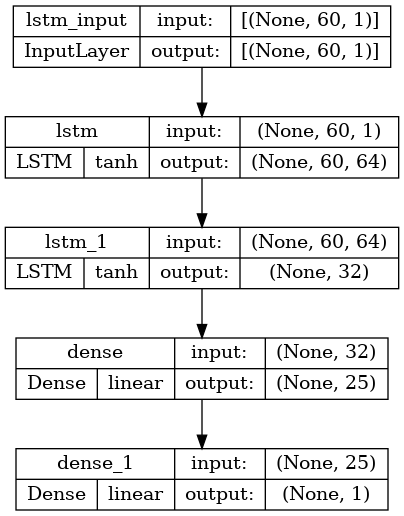

In [14]:
plot_model(model, to_file="model.png", show_shapes=True, show_layer_activations=True)


In [15]:
X_test, y_test = prep_data(test, lookback)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [16]:
predictions = scaler.inverse_transform(model.predict(X_test))
predictions


2023-05-05 09:33:18.809974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 09:33:18.811351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 09:33:18.812355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 10ms/step


array([[164.85724],
       [166.69766],
       [168.24316],
       [169.19162],
       [169.70906],
       [170.31105],
       [170.566  ],
       [170.33719],
       [169.91263],
       [169.23155],
       [168.09213],
       [167.015  ],
       [166.31778],
       [165.4132 ],
       [164.49765],
       [163.88289],
       [163.4671 ],
       [163.13101],
       [162.44606],
       [161.76547],
       [160.57527],
       [159.23402],
       [158.60858],
       [157.8402 ],
       [157.13535],
       [156.67683],
       [157.01141],
       [156.84465],
       [156.53842],
       [155.68036],
       [154.86293],
       [153.3674 ],
       [151.30325],
       [149.58192],
       [148.05   ],
       [147.1453 ],
       [145.8499 ],
       [144.16531],
       [142.46693],
       [141.46806],
       [140.67412],
       [140.10326],
       [140.03282],
       [140.80858],
       [141.88078],
       [142.9999 ],
       [144.27246],
       [144.92632],
       [145.26636],
       [145.64111],


In [17]:
rmse = mean_squared_error(predictions, y_test, squared=False)
rmse


5.342747970119301

In [18]:
r2 = r2_score(predictions, y_test)
r2


0.7141562706990553

In [19]:
results_df = pd.DataFrame(y_test, columns=["Close"])
results_df["Close_pred"] = predictions
results_df


,Close,Close_pred
0,177.882462,164.857239
1,176.699615,166.697662
2,173.558624,168.243164
3,173.260437,169.191620
4,177.365570,169.709061
...,...,...
187,131.658981,135.416397
188,129.831772,134.421417
189,125.847855,133.409271
190,129.412415,132.102798


In [20]:
px.line(results_df)


In [21]:
aapl_60_days_close = yf.Ticker("AAPL").history(period="60d")["Close"].values
last_60_days_close_scaled = scaler.transform(aapl_60_days_close.reshape(-1, 1))

X = np.reshape(last_60_days_close_scaled, (1, -1, 1))
y_pred = scaler.inverse_transform(model.predict(X, verbose=0))

y_pred.item()


2023-05-05 09:33:20.063710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 09:33:20.064934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 09:33:20.065957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

164.67860412597656

In [22]:
joblib.dump(model, "bullseye/viz/model.pkl")
joblib.dump(scaler, "bullseye/viz/scaler.pkl")


['bullseye/viz/scaler.pkl']

## Baseline Performance


In [23]:
aapl_history["Close_pred"] = aapl_history["Close"].shift(1)
aapl_history = aapl_history.dropna()
aapl_history


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_pred
Date,,,,,,,,
2018-01-03 00:00:00-05:00,40.952160,41.431634,40.816866,40.880951,118071600,0.0,0.0,40.888077
2018-01-04 00:00:00-05:00,40.954530,41.175279,40.845345,41.070839,89738400,0.0,0.0,40.880951
2018-01-05 00:00:00-05:00,41.168152,41.626260,41.075581,41.538437,94640000,0.0,0.0,41.070839
2018-01-08 00:00:00-05:00,41.384151,41.683227,41.284456,41.384151,82271200,0.0,0.0,41.538437
2018-01-09 00:00:00-05:00,41.431630,41.552683,41.161037,41.379410,86336000,0.0,0.0,41.384151
...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,130.720412,132.218125,129.442364,131.658981,63814900,0.0,0.0,132.028412
2022-12-27 00:00:00-05:00,131.179720,131.209673,128.523771,129.831772,69007800,0.0,0.0,131.658981
2022-12-28 00:00:00-05:00,129.472318,130.830245,125.678116,125.847855,85438400,0.0,0.0,129.831772


In [24]:
rmse = mean_squared_error(
    aapl_history["Close_pred"], aapl_history["Close"], squared=False
)
rmse


2.2023758669739832

In [25]:
r2 = r2_score(aapl_history["Close_pred"], aapl_history["Close"])
r2


0.9977659024599131

In [26]:
px.line(aapl_history[["Close", "Close_pred"]])
